In [1]:
from bs4 import BeautifulSoup # For HTML parsing
import requests# Website connections
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
%matplotlib inline

In [2]:
url = 'https://www.indeed.com/jobs?q=data+scientist&l=New+York%2C+NY'
req = requests.get(url)
source = req.text  

bs_tree = BeautifulSoup(source, 'html.parser')
print(bs_tree.prettify())

<!DOCTYPE html>
<html dir="ltr" lang="en">
 <head>
  <meta content="text/html;charset=utf-8" http-equiv="content-type"/>
  <script src="/s/798993d/en_US.js" type="text/javascript">
  </script>
  <script>
   window.indeed=window.indeed||{};indeed.crashtext=indeed.crashtext||{};indeed.crashtext.populate=indeed.crashtext.populate||function(c,g){var d=window[g];if(d){var e=d[""]||{},h=e.salt;if(e.hasOwnProperty("salt"))for(var b in c){for(var a=void 0,a=h,f=b.length;f;)a=33*a^b.charCodeAt(--f);a>>>=0;e.hasOwnProperty("id_length")&&(a=String(a).substring(0,e.id_length));d[a]=c[b]}else for(b in c)d[b]=[null].concat(c[b])}};indeed.crashtext.populate({"indeedapply_serp_label":["Easy apply"],"Turn on":["Subscribe"],"See new jobs for this search":["Get email alerts for this search"]}, 'indeed.i18n.localeData')
  </script>
  <link href="/s/60d7c47/jobsearch_all.css" rel="stylesheet" type="text/css"/>
  <link href="http://rss.indeed.com/rss?q=data+scientist&amp;l=New+York%2C+NY" rel="alternate" ti

In [3]:
job_page_string = bs_tree.find(id = 'searchCountPages').contents[0]
job_page_string = job_page_string.split()[-2]
job_page_string

'958'

In [4]:
page_count_digits = [int(i) for i in job_page_string if i.isdigit() ]
page_count_digits

[9, 5, 8]

In [5]:
num_pages = 0
exp = len(page_count_digits) -1
for i in page_count_digits:
    num_pages = num_pages + i*(10**exp)
    exp -= 1
print(num_pages)

958


In [6]:
from urllib.parse import urljoin
import time
base_url = 'http://www.indeed.com'
job_links = []

for i in range(1,5):    #搜索结果1-3页
    
    # 为第i页创建 bs object
    url = 'https://www.indeed.com/jobs?q=data+scientist&l=New+York%2C+NY&start=' + str(i*10)    #创建第i页的url   
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'lxml')
    
    divs = soup.find_all('div', class_="title")    # each link is under a div tab
    href_links = [item.a.get('href') for item in divs]    # create a list of all href links
    
    
    for href_link in href_links:
        job_links.append(urljoin(base_url, href_link))    # create招聘页面的完整网址，并将其添加到 job_links 列表中
    
    time.sleep(0.5)    # 怕把服务器累死，be nice

In [7]:
len(job_links)

65

In [8]:
for i in job_links:
    print(i)

http://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0Ab67y_gTDH9tSaT0HLOcX4Q3W4UsL2WfVRyJV-qqww-S_SOAUpqHEOp-BmnzQ8WvS2hjVcNV04-JtanPARWfTnBzh5obZQOXp_nIWhin1GXrLkcUG2dkzbkxQDa736Xk9Q-kTtPAMs_CC3HkFbaAe-EuocJkL53eTtFhbxSbIiQBo5-PHED_tqLX7uiUhhU98PWQqEVvCBeqzG7xueQswynejFxXZaNCoeYdWbJ30ozxShFoamC7NAwo4X4JElZIlj5wv_pYZZrfq8guYXywVjeC1_rpgFBwrgjzcXALpL8VAoyyUtKcXfrX8d8GrtKMsf_PKm_9r7CsMGLmwkxdpaNVAoM9wWIAdyPKV_WX9mFPi0hPYH-tgsJ4BW-DLmdRvuunCTEmfU5CMbscmeLXZXcA-hmXXWMMBYFVCwg9Hs8F07kAmkBivLg0jfZYtz6lGrhdDLZHBL8otE3lbFACGOSA7orOCrS4W1MYpy2DY7IEe-6wouACcfYY9ZzE4Oqr2W2PMQRfbUtk-Q0a1ugm-pKYpsMlLc92maivhA6k6LcMypPfhK57uEaRg5Zi_4yJrNDudm4C4XOPx3O1onBUhifGyagAMwYJbPtkIrsdK8aRbtykQnBso0anH31OzegI85OFTZLwrm4zCce77MBmQwr57uw7Z-AVO7_t7pyiunbfHoR9GM0r_byGc5VM4A2w_SwVDz0uW0qkTNq2Onvtu1n6l6EFLVv6DYkbpTkvQEL2iFZlIt78FxlbRazKvi232250jRFGL2mQ==&p=0&fvj=0&vjs=3
http://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0DIXU_djF9v0NrX_xbLRwj6RWFeuMEgTY6VvwKgvleOVN2aNd4LWgpeKXIdsYXWhN5FB30cKwObd3P2eOiE6xXr0Hvy2pv14OylW

In [19]:
import urllib

skill_set = {'python': 0, 'spark':0}
counter = 0

for link in job_links:
    counter += 1
    
    try:
        html_page = str(urllib.request.urlopen(link).read())
    except urllib.error.HTTPError:
        print('HTTPError')
        continue
    except urllib.error.URLError:
        print('URLError')
        continue
    except socket.error as error:
        print('Connection closed')
        continue
        
    
    html_text = re.sub("[^a-z.+3]"," ", html_page.lower())
    
    for key in skill_set.keys():
        if key in html_text:
            skill_set[key] += 1
            
    if counter % 5 == 0:
        print(len(job_links) - counter)
        print(skill_set)

60
{'python': 5, 'spark': 3}
55
{'python': 10, 'spark': 3}
50
{'python': 13, 'spark': 4}
45
{'python': 16, 'spark': 5}
40
{'python': 20, 'spark': 6}
35
{'python': 25, 'spark': 6}
30
{'python': 30, 'spark': 9}
25
{'python': 33, 'spark': 9}
20
{'python': 37, 'spark': 10}
15
{'python': 42, 'spark': 13}
10
{'python': 45, 'spark': 13}
5
{'python': 50, 'spark': 15}
0
{'python': 54, 'spark': 17}


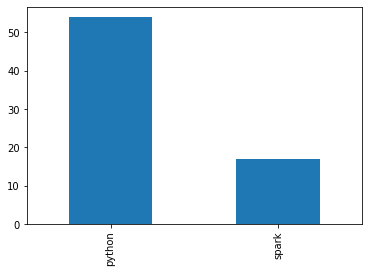

In [21]:
pseries = pd.Series(skill_set)
pseries.plot(kind = 'bar')